In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
torch.manual_seed(42)

from torch.utils.data import DataLoader, TensorDataset

from model0 import Model0
from model1 import Model1
from model2 import Model2
import numpy as np

# from model0_cross_entropy import Model0
# from model1_cross_entropy import Model1
# from model2_cross_entropy import Model2

In [2]:
import os

result_folder = "finalResult_with_grad4_final5"

if not os.path.exists(result_folder):
    os.mkdir(result_folder)

In [3]:
from config import batch_size

In [4]:
Y_func = lambda x : (torch.sin(5*np.pi*x)) /(5*np.pi*x) 

In [5]:
num_of_rows = 300

In [6]:
num_of_rows = 300
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)


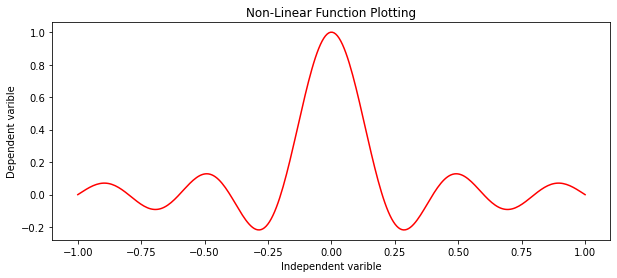

In [7]:
plt.figure(figsize=(10,4))
plt.plot(X, Y, color = "red")
plt.title('Non-Linear Function Plotting')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.savefig(result_folder+'/func1_plot.png')

In [8]:
X.shape

torch.Size([300, 1])

In [9]:
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

In [10]:
model_0 = Model0()
model_1 = Model1()
model_2 = Model2()

In [11]:
lr = 0.0004
gamma_lr_scheduler = 0.1 
weight_decay = 1e-4


In [12]:
# def get_criterion_optimizer_schedular(model,lr,gamma,weight_decay):
#     criterion = nn.CrossEntropyLoss()
    
#     optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=weight_decay)
    
#     exp_lr_scheduler = lr_scheduler.StepLR(
#     optimizer, step_size=10, gamma=gamma_lr_scheduler
#     )
    
#     return criterion,optimizer,exp_lr_scheduler

In [13]:
# criterion,optimizer,scheduler = get_criterion_optimizer_schedular(model_0,lr,gamma_lr_scheduler,weight_decay)

In [14]:
# v1

# def evaluate(model, val_loader):
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)

# def evaluate2(model, train_loader):
#     outputs = [model.train_step(batch) for batch in train_loader]
#     return model.train_epoch_end(outputs)

# def fit(epochs, lr, model, data_loader, criterion,opt_func=torch.optim.SGD):
#     history = []
# #     train_history = []
#     optimizer = opt_func(model.parameters(), lr)
#     for epoch in range(epochs):
#         # Training Phase 
#         for batch in data_loader:
#             loss = model.training_step(batch)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#         # Validation phase
#         result = evaluate(model, data_loader)
#         model.epoch_end(epoch, result)
#         history.append(result)
# #         res2 = evaluate2(model,train_loader)
# #         train_history.append(res2)
#     return history

In [15]:
# v1

# result_0 = evaluate(model_0,data_loader)
# result_1 = evaluate(model_1,data_loader)
# result_2 = evaluate(model_2,data_loader)

# result_0,result_1,result_2

In [16]:
# v1

# print("MODEL 0")
# history_0 = fit(2000, lr, model_0, data_loader,criterion)
# print("MODEL 1")
# history_1  = fit(2000, lr, model_1, data_loader, criterion)
# print("MODEL 2")
# history_2  = fit(2000, lr, model_2, data_loader, criterion)

In [17]:
# v2
def evaluate(model,loss_fn, val_loader):
    outputs = [model.validation_step(batch,loss_fn) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def evaluate2(model,loss_fn, train_loader):
    outputs = [model.train_step(batch,loss_fn) for batch in train_loader]
    return model.train_epoch_end(outputs)

def get_grad_norm(model):
    grad_all=0.0
    grad =0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm


def fit(epochs, lr, model, data_loader, criterion,opt_func):
    history = []
    comparing_epoch_loss =1000.0
    grad_norm_per_epoch={}
#     train_history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
#         grad_norm_per_epoch[epoch] = get_grad_norm(model)
        
        if epoch > 900 and epoch%100 ==0:
            print("Comparing result:", (comparing_epoch_loss - result["val_loss"]))
            if (comparing_epoch_loss - result["val_loss"])  < 0.000001:
#                 print("Comparing result:", (comparing_epoch_loss - result["val_loss"]))
                break
            comparing_epoch_loss=result["val_loss"]
        
        # Training Phase 
        for batch in data_loader:
            loss = model.training_step(batch,criterion)
            loss.backward()
            optimizer.step()
            grad_norm_per_epoch[epoch] = get_grad_norm(model)
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model,criterion, data_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
        if epoch == 900:
            comparing_epoch_loss= result["val_loss"]
        
#         res2 = evaluate2(model,train_loader)
#         train_history.append(res2)
    return history,grad_norm_per_epoch

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =20000
criterion_name = "MSE_LOSS_"
optimizer_name = "ADAM_opt"

In [19]:
filename = criterion_name+ optimizer_name+".png"
filename

'MSE_LOSS_ADAM_opt.png'

In [20]:
# criterion = [nn.MSELoss()]
# optimizer = [torch.optim.Adam]
# num_epochs =2000
# criterion_name = ["MSE_LOSS"]
# optimizer_name = ["ADAM_opt"]

In [21]:
result_0 = evaluate(model_0,criterion,data_loader)
result_1 = evaluate(model_1,criterion,data_loader)
result_2 = evaluate(model_2,criterion,data_loader)

result_0,result_1,result_2

({'val_loss': 0.22771821916103363},
 {'val_loss': 0.20846916735172272},
 {'val_loss': 0.09984073787927628})

In [22]:
print("MODEL 0")
history_0,grad_norm_0 = fit(num_epochs, lr, model_0, data_loader,criterion,optimizer)
print("MODEL 1")
history_1,grad_norm_1  = fit(num_epochs, lr, model_1, data_loader, criterion,optimizer)
print("MODEL 2")
history_2,grad_norm_2  = fit(num_epochs, lr, model_2, data_loader, criterion,optimizer)

MODEL 0
Epoch [0], val_loss: 0.1615
Epoch [1], val_loss: 0.0876
Epoch [2], val_loss: 0.0878
Epoch [3], val_loss: 0.0874
Epoch [4], val_loss: 0.0873
Epoch [5], val_loss: 0.0875
Epoch [6], val_loss: 0.0874
Epoch [7], val_loss: 0.0872
Epoch [8], val_loss: 0.0874
Epoch [9], val_loss: 0.0872
Epoch [10], val_loss: 0.0872
Epoch [11], val_loss: 0.0871
Epoch [12], val_loss: 0.0873
Epoch [13], val_loss: 0.0871
Epoch [14], val_loss: 0.0871
Epoch [15], val_loss: 0.0871
Epoch [16], val_loss: 0.0873
Epoch [17], val_loss: 0.0871
Epoch [18], val_loss: 0.0871
Epoch [19], val_loss: 0.0871
Epoch [20], val_loss: 0.0871
Epoch [21], val_loss: 0.0870
Epoch [22], val_loss: 0.0871
Epoch [23], val_loss: 0.0871
Epoch [24], val_loss: 0.0871
Epoch [25], val_loss: 0.0872
Epoch [26], val_loss: 0.0870
Epoch [27], val_loss: 0.0870
Epoch [28], val_loss: 0.0870
Epoch [29], val_loss: 0.0875
Epoch [30], val_loss: 0.0870
Epoch [31], val_loss: 0.0870
Epoch [32], val_loss: 0.0871
Epoch [33], val_loss: 0.0869
Epoch [34], val_

Epoch [277], val_loss: 0.0075
Epoch [278], val_loss: 0.0073
Epoch [279], val_loss: 0.0081
Epoch [280], val_loss: 0.0073
Epoch [281], val_loss: 0.0072
Epoch [282], val_loss: 0.0075
Epoch [283], val_loss: 0.0076
Epoch [284], val_loss: 0.0074
Epoch [285], val_loss: 0.0073
Epoch [286], val_loss: 0.0074
Epoch [287], val_loss: 0.0077
Epoch [288], val_loss: 0.0072
Epoch [289], val_loss: 0.0076
Epoch [290], val_loss: 0.0072
Epoch [291], val_loss: 0.0076
Epoch [292], val_loss: 0.0086
Epoch [293], val_loss: 0.0074
Epoch [294], val_loss: 0.0074
Epoch [295], val_loss: 0.0072
Epoch [296], val_loss: 0.0086
Epoch [297], val_loss: 0.0076
Epoch [298], val_loss: 0.0073
Epoch [299], val_loss: 0.0071
Epoch [300], val_loss: 0.0073
Epoch [301], val_loss: 0.0073
Epoch [302], val_loss: 0.0073
Epoch [303], val_loss: 0.0072
Epoch [304], val_loss: 0.0080
Epoch [305], val_loss: 0.0075
Epoch [306], val_loss: 0.0073
Epoch [307], val_loss: 0.0072
Epoch [308], val_loss: 0.0072
Epoch [309], val_loss: 0.0072
Epoch [310

Epoch [551], val_loss: 0.0070
Epoch [552], val_loss: 0.0072
Epoch [553], val_loss: 0.0070
Epoch [554], val_loss: 0.0070
Epoch [555], val_loss: 0.0069
Epoch [556], val_loss: 0.0073
Epoch [557], val_loss: 0.0071
Epoch [558], val_loss: 0.0076
Epoch [559], val_loss: 0.0069
Epoch [560], val_loss: 0.0069
Epoch [561], val_loss: 0.0071
Epoch [562], val_loss: 0.0071
Epoch [563], val_loss: 0.0071
Epoch [564], val_loss: 0.0070
Epoch [565], val_loss: 0.0069
Epoch [566], val_loss: 0.0069
Epoch [567], val_loss: 0.0070
Epoch [568], val_loss: 0.0070
Epoch [569], val_loss: 0.0068
Epoch [570], val_loss: 0.0068
Epoch [571], val_loss: 0.0069
Epoch [572], val_loss: 0.0068
Epoch [573], val_loss: 0.0074
Epoch [574], val_loss: 0.0073
Epoch [575], val_loss: 0.0068
Epoch [576], val_loss: 0.0072
Epoch [577], val_loss: 0.0068
Epoch [578], val_loss: 0.0068
Epoch [579], val_loss: 0.0072
Epoch [580], val_loss: 0.0067
Epoch [581], val_loss: 0.0072
Epoch [582], val_loss: 0.0071
Epoch [583], val_loss: 0.0067
Epoch [584

Epoch [825], val_loss: 0.0072
Epoch [826], val_loss: 0.0068
Epoch [827], val_loss: 0.0070
Epoch [828], val_loss: 0.0068
Epoch [829], val_loss: 0.0068
Epoch [830], val_loss: 0.0068
Epoch [831], val_loss: 0.0070
Epoch [832], val_loss: 0.0071
Epoch [833], val_loss: 0.0069
Epoch [834], val_loss: 0.0069
Epoch [835], val_loss: 0.0068
Epoch [836], val_loss: 0.0069
Epoch [837], val_loss: 0.0073
Epoch [838], val_loss: 0.0079
Epoch [839], val_loss: 0.0068
Epoch [840], val_loss: 0.0070
Epoch [841], val_loss: 0.0069
Epoch [842], val_loss: 0.0069
Epoch [843], val_loss: 0.0069
Epoch [844], val_loss: 0.0069
Epoch [845], val_loss: 0.0071
Epoch [846], val_loss: 0.0071
Epoch [847], val_loss: 0.0068
Epoch [848], val_loss: 0.0068
Epoch [849], val_loss: 0.0068
Epoch [850], val_loss: 0.0067
Epoch [851], val_loss: 0.0067
Epoch [852], val_loss: 0.0068
Epoch [853], val_loss: 0.0068
Epoch [854], val_loss: 0.0069
Epoch [855], val_loss: 0.0068
Epoch [856], val_loss: 0.0069
Epoch [857], val_loss: 0.0068
Epoch [858

Epoch [1094], val_loss: 0.0051
Epoch [1095], val_loss: 0.0052
Epoch [1096], val_loss: 0.0050
Epoch [1097], val_loss: 0.0047
Epoch [1098], val_loss: 0.0051
Epoch [1099], val_loss: 0.0048
Comparing result: 0.0017960336990654469
Epoch [1100], val_loss: 0.0051
Epoch [1101], val_loss: 0.0047
Epoch [1102], val_loss: 0.0046
Epoch [1103], val_loss: 0.0049
Epoch [1104], val_loss: 0.0049
Epoch [1105], val_loss: 0.0047
Epoch [1106], val_loss: 0.0046
Epoch [1107], val_loss: 0.0074
Epoch [1108], val_loss: 0.0054
Epoch [1109], val_loss: 0.0048
Epoch [1110], val_loss: 0.0046
Epoch [1111], val_loss: 0.0047
Epoch [1112], val_loss: 0.0049
Epoch [1113], val_loss: 0.0047
Epoch [1114], val_loss: 0.0048
Epoch [1115], val_loss: 0.0054
Epoch [1116], val_loss: 0.0046
Epoch [1117], val_loss: 0.0047
Epoch [1118], val_loss: 0.0053
Epoch [1119], val_loss: 0.0061
Epoch [1120], val_loss: 0.0050
Epoch [1121], val_loss: 0.0048
Epoch [1122], val_loss: 0.0048
Epoch [1123], val_loss: 0.0064
Epoch [1124], val_loss: 0.0061

Epoch [1355], val_loss: 0.0043
Epoch [1356], val_loss: 0.0046
Epoch [1357], val_loss: 0.0040
Epoch [1358], val_loss: 0.0043
Epoch [1359], val_loss: 0.0040
Epoch [1360], val_loss: 0.0040
Epoch [1361], val_loss: 0.0041
Epoch [1362], val_loss: 0.0045
Epoch [1363], val_loss: 0.0040
Epoch [1364], val_loss: 0.0040
Epoch [1365], val_loss: 0.0041
Epoch [1366], val_loss: 0.0041
Epoch [1367], val_loss: 0.0047
Epoch [1368], val_loss: 0.0040
Epoch [1369], val_loss: 0.0040
Epoch [1370], val_loss: 0.0041
Epoch [1371], val_loss: 0.0042
Epoch [1372], val_loss: 0.0043
Epoch [1373], val_loss: 0.0039
Epoch [1374], val_loss: 0.0041
Epoch [1375], val_loss: 0.0040
Epoch [1376], val_loss: 0.0040
Epoch [1377], val_loss: 0.0040
Epoch [1378], val_loss: 0.0045
Epoch [1379], val_loss: 0.0040
Epoch [1380], val_loss: 0.0042
Epoch [1381], val_loss: 0.0044
Epoch [1382], val_loss: 0.0042
Epoch [1383], val_loss: 0.0040
Epoch [1384], val_loss: 0.0040
Epoch [1385], val_loss: 0.0043
Epoch [1386], val_loss: 0.0040
Epoch [1

Epoch [124], val_loss: 0.0871
Epoch [125], val_loss: 0.0869
Epoch [126], val_loss: 0.0869
Epoch [127], val_loss: 0.0869
Epoch [128], val_loss: 0.0871
Epoch [129], val_loss: 0.0870
Epoch [130], val_loss: 0.0872
Epoch [131], val_loss: 0.0869
Epoch [132], val_loss: 0.0869
Epoch [133], val_loss: 0.0869
Epoch [134], val_loss: 0.0870
Epoch [135], val_loss: 0.0870
Epoch [136], val_loss: 0.0869
Epoch [137], val_loss: 0.0872
Epoch [138], val_loss: 0.0874
Epoch [139], val_loss: 0.0869
Epoch [140], val_loss: 0.0869
Epoch [141], val_loss: 0.0869
Epoch [142], val_loss: 0.0869
Epoch [143], val_loss: 0.0870
Epoch [144], val_loss: 0.0869
Epoch [145], val_loss: 0.0869
Epoch [146], val_loss: 0.0871
Epoch [147], val_loss: 0.0870
Epoch [148], val_loss: 0.0869
Epoch [149], val_loss: 0.0871
Epoch [150], val_loss: 0.0870
Epoch [151], val_loss: 0.0869
Epoch [152], val_loss: 0.0870
Epoch [153], val_loss: 0.0869
Epoch [154], val_loss: 0.0870
Epoch [155], val_loss: 0.0869
Epoch [156], val_loss: 0.0870
Epoch [157

Epoch [398], val_loss: 0.0869
Epoch [399], val_loss: 0.0869
Epoch [400], val_loss: 0.0869
Epoch [401], val_loss: 0.0869
Epoch [402], val_loss: 0.0869
Epoch [403], val_loss: 0.0869
Epoch [404], val_loss: 0.0869
Epoch [405], val_loss: 0.0869
Epoch [406], val_loss: 0.0870
Epoch [407], val_loss: 0.0869
Epoch [408], val_loss: 0.0869
Epoch [409], val_loss: 0.0869
Epoch [410], val_loss: 0.0869
Epoch [411], val_loss: 0.0870
Epoch [412], val_loss: 0.0870
Epoch [413], val_loss: 0.0870
Epoch [414], val_loss: 0.0869
Epoch [415], val_loss: 0.0869
Epoch [416], val_loss: 0.0869
Epoch [417], val_loss: 0.0869
Epoch [418], val_loss: 0.0869
Epoch [419], val_loss: 0.0871
Epoch [420], val_loss: 0.0869
Epoch [421], val_loss: 0.0869
Epoch [422], val_loss: 0.0869
Epoch [423], val_loss: 0.0869
Epoch [424], val_loss: 0.0869
Epoch [425], val_loss: 0.0870
Epoch [426], val_loss: 0.0869
Epoch [427], val_loss: 0.0869
Epoch [428], val_loss: 0.0869
Epoch [429], val_loss: 0.0869
Epoch [430], val_loss: 0.0869
Epoch [431

Epoch [672], val_loss: 0.0017
Epoch [673], val_loss: 0.0019
Epoch [674], val_loss: 0.0019
Epoch [675], val_loss: 0.0017
Epoch [676], val_loss: 0.0018
Epoch [677], val_loss: 0.0017
Epoch [678], val_loss: 0.0017
Epoch [679], val_loss: 0.0019
Epoch [680], val_loss: 0.0020
Epoch [681], val_loss: 0.0019
Epoch [682], val_loss: 0.0017
Epoch [683], val_loss: 0.0018
Epoch [684], val_loss: 0.0018
Epoch [685], val_loss: 0.0017
Epoch [686], val_loss: 0.0022
Epoch [687], val_loss: 0.0019
Epoch [688], val_loss: 0.0017
Epoch [689], val_loss: 0.0018
Epoch [690], val_loss: 0.0018
Epoch [691], val_loss: 0.0017
Epoch [692], val_loss: 0.0017
Epoch [693], val_loss: 0.0017
Epoch [694], val_loss: 0.0018
Epoch [695], val_loss: 0.0017
Epoch [696], val_loss: 0.0017
Epoch [697], val_loss: 0.0018
Epoch [698], val_loss: 0.0017
Epoch [699], val_loss: 0.0017
Epoch [700], val_loss: 0.0017
Epoch [701], val_loss: 0.0017
Epoch [702], val_loss: 0.0017
Epoch [703], val_loss: 0.0017
Epoch [704], val_loss: 0.0017
Epoch [705

Epoch [946], val_loss: 0.0015
Epoch [947], val_loss: 0.0015
Epoch [948], val_loss: 0.0016
Epoch [949], val_loss: 0.0016
Epoch [950], val_loss: 0.0016
Epoch [951], val_loss: 0.0015
Epoch [952], val_loss: 0.0016
Epoch [953], val_loss: 0.0015
Epoch [954], val_loss: 0.0015
Epoch [955], val_loss: 0.0016
Epoch [956], val_loss: 0.0015
Epoch [957], val_loss: 0.0016
Epoch [958], val_loss: 0.0015
Epoch [959], val_loss: 0.0017
Epoch [960], val_loss: 0.0015
Epoch [961], val_loss: 0.0015
Epoch [962], val_loss: 0.0017
Epoch [963], val_loss: 0.0018
Epoch [964], val_loss: 0.0016
Epoch [965], val_loss: 0.0016
Epoch [966], val_loss: 0.0015
Epoch [967], val_loss: 0.0017
Epoch [968], val_loss: 0.0015
Epoch [969], val_loss: 0.0016
Epoch [970], val_loss: 0.0017
Epoch [971], val_loss: 0.0016
Epoch [972], val_loss: 0.0016
Epoch [973], val_loss: 0.0015
Epoch [974], val_loss: 0.0020
Epoch [975], val_loss: 0.0016
Epoch [976], val_loss: 0.0015
Epoch [977], val_loss: 0.0015
Epoch [978], val_loss: 0.0016
Epoch [979

Epoch [117], val_loss: 0.0050
Epoch [118], val_loss: 0.0046
Epoch [119], val_loss: 0.0049
Epoch [120], val_loss: 0.0098
Epoch [121], val_loss: 0.0051
Epoch [122], val_loss: 0.0054
Epoch [123], val_loss: 0.0056
Epoch [124], val_loss: 0.0044
Epoch [125], val_loss: 0.0044
Epoch [126], val_loss: 0.0055
Epoch [127], val_loss: 0.0044
Epoch [128], val_loss: 0.0049
Epoch [129], val_loss: 0.0081
Epoch [130], val_loss: 0.0063
Epoch [131], val_loss: 0.0061
Epoch [132], val_loss: 0.0043
Epoch [133], val_loss: 0.0042
Epoch [134], val_loss: 0.0045
Epoch [135], val_loss: 0.0041
Epoch [136], val_loss: 0.0044
Epoch [137], val_loss: 0.0052
Epoch [138], val_loss: 0.0072
Epoch [139], val_loss: 0.0042
Epoch [140], val_loss: 0.0041
Epoch [141], val_loss: 0.0044
Epoch [142], val_loss: 0.0039
Epoch [143], val_loss: 0.0057
Epoch [144], val_loss: 0.0042
Epoch [145], val_loss: 0.0042
Epoch [146], val_loss: 0.0057
Epoch [147], val_loss: 0.0048
Epoch [148], val_loss: 0.0045
Epoch [149], val_loss: 0.0120
Epoch [150

Epoch [391], val_loss: 0.0029
Epoch [392], val_loss: 0.0027
Epoch [393], val_loss: 0.0021
Epoch [394], val_loss: 0.0020
Epoch [395], val_loss: 0.0021
Epoch [396], val_loss: 0.0019
Epoch [397], val_loss: 0.0018
Epoch [398], val_loss: 0.0020
Epoch [399], val_loss: 0.0031
Epoch [400], val_loss: 0.0018
Epoch [401], val_loss: 0.0029
Epoch [402], val_loss: 0.0019
Epoch [403], val_loss: 0.0018
Epoch [404], val_loss: 0.0018
Epoch [405], val_loss: 0.0054
Epoch [406], val_loss: 0.0017
Epoch [407], val_loss: 0.0028
Epoch [408], val_loss: 0.0022
Epoch [409], val_loss: 0.0031
Epoch [410], val_loss: 0.0028
Epoch [411], val_loss: 0.0018
Epoch [412], val_loss: 0.0036
Epoch [413], val_loss: 0.0024
Epoch [414], val_loss: 0.0021
Epoch [415], val_loss: 0.0018
Epoch [416], val_loss: 0.0020
Epoch [417], val_loss: 0.0017
Epoch [418], val_loss: 0.0037
Epoch [419], val_loss: 0.0039
Epoch [420], val_loss: 0.0024
Epoch [421], val_loss: 0.0018
Epoch [422], val_loss: 0.0028
Epoch [423], val_loss: 0.0029
Epoch [424

Epoch [665], val_loss: 0.0025
Epoch [666], val_loss: 0.0018
Epoch [667], val_loss: 0.0022
Epoch [668], val_loss: 0.0017
Epoch [669], val_loss: 0.0017
Epoch [670], val_loss: 0.0024
Epoch [671], val_loss: 0.0014
Epoch [672], val_loss: 0.0018
Epoch [673], val_loss: 0.0017
Epoch [674], val_loss: 0.0045
Epoch [675], val_loss: 0.0036
Epoch [676], val_loss: 0.0018
Epoch [677], val_loss: 0.0016
Epoch [678], val_loss: 0.0016
Epoch [679], val_loss: 0.0015
Epoch [680], val_loss: 0.0019
Epoch [681], val_loss: 0.0018
Epoch [682], val_loss: 0.0030
Epoch [683], val_loss: 0.0019
Epoch [684], val_loss: 0.0015
Epoch [685], val_loss: 0.0019
Epoch [686], val_loss: 0.0015
Epoch [687], val_loss: 0.0015
Epoch [688], val_loss: 0.0014
Epoch [689], val_loss: 0.0035
Epoch [690], val_loss: 0.0015
Epoch [691], val_loss: 0.0033
Epoch [692], val_loss: 0.0017
Epoch [693], val_loss: 0.0014
Epoch [694], val_loss: 0.0019
Epoch [695], val_loss: 0.0021
Epoch [696], val_loss: 0.0015
Epoch [697], val_loss: 0.0014
Epoch [698

Epoch [939], val_loss: 0.0017
Epoch [940], val_loss: 0.0013
Epoch [941], val_loss: 0.0014
Epoch [942], val_loss: 0.0016
Epoch [943], val_loss: 0.0021
Epoch [944], val_loss: 0.0045
Epoch [945], val_loss: 0.0058
Epoch [946], val_loss: 0.0017
Epoch [947], val_loss: 0.0014
Epoch [948], val_loss: 0.0016
Epoch [949], val_loss: 0.0022
Epoch [950], val_loss: 0.0017
Epoch [951], val_loss: 0.0015
Epoch [952], val_loss: 0.0024
Epoch [953], val_loss: 0.0015
Epoch [954], val_loss: 0.0016
Epoch [955], val_loss: 0.0014
Epoch [956], val_loss: 0.0018
Epoch [957], val_loss: 0.0016
Epoch [958], val_loss: 0.0022
Epoch [959], val_loss: 0.0070
Epoch [960], val_loss: 0.0014
Epoch [961], val_loss: 0.0017
Epoch [962], val_loss: 0.0014
Epoch [963], val_loss: 0.0016
Epoch [964], val_loss: 0.0030
Epoch [965], val_loss: 0.0017
Epoch [966], val_loss: 0.0020
Epoch [967], val_loss: 0.0016
Epoch [968], val_loss: 0.0038
Epoch [969], val_loss: 0.0021
Epoch [970], val_loss: 0.0014
Epoch [971], val_loss: 0.0016
Epoch [972

In [43]:
val_losses_0 = [r['val_loss'] for r in [result_0] + history_0]
val_losses_1 = [r['val_loss'] for r in [result_1] + history_1]
val_losses_2 = [r['val_loss'] for r in [result_2] + history_2]

In [44]:
val_losses_0_div_100 = [value for index,value in enumerate(val_losses_0) if (index % 10) ==0 ]
val_losses_1_div_100 = [value for index,value in enumerate(val_losses_1) if (index % 10) ==0 ]
val_losses_2_div_100 = [value for index,value in enumerate(val_losses_2) if (index % 10) ==0 ]


In [45]:
# grad_norm_0,grad_norm_1,grad_norm_2

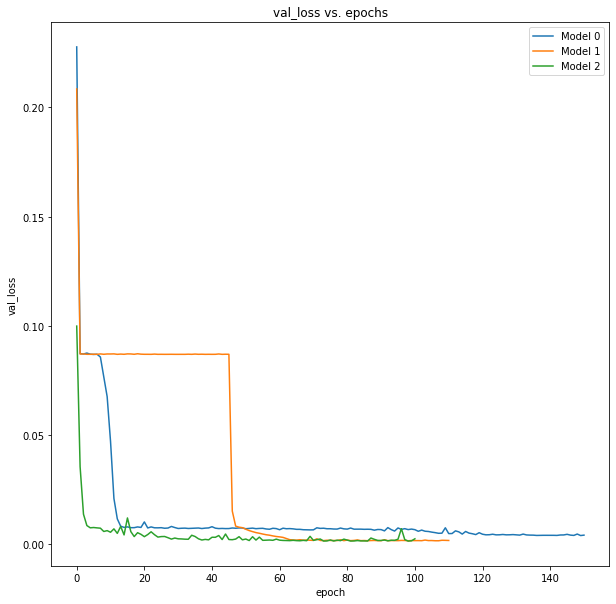

In [56]:
plt.figure(figsize=(10,10))
plt.plot(val_losses_0_div_100)
plt.plot(val_losses_1_div_100)
plt.plot(val_losses_2_div_100)
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.legend(['Model 0','Model 1','Model 2'])
plt.title('val_loss vs. epochs');

plt.savefig("loss_eps_convergence"+filename)

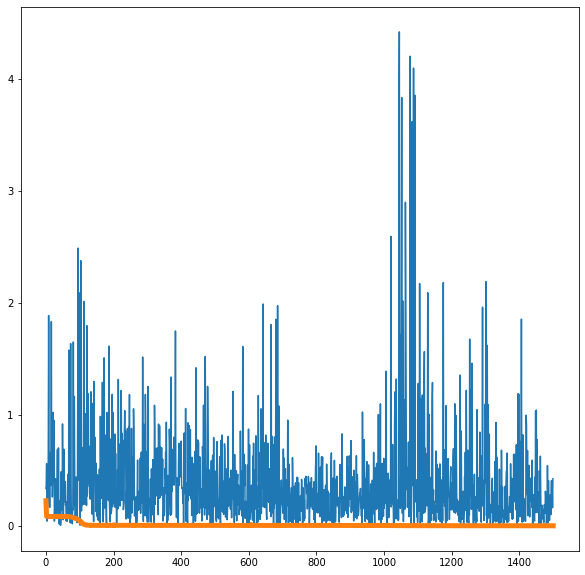

<Figure size 432x288 with 0 Axes>

In [52]:
plt.figure(figsize=(10,10))
plt.plot(grad_norm_0.values())
plt.plot(val_losses_0,linewidth=5)
plt.show()
plt.savefig("grad_norm_loss_model0_"+filename)

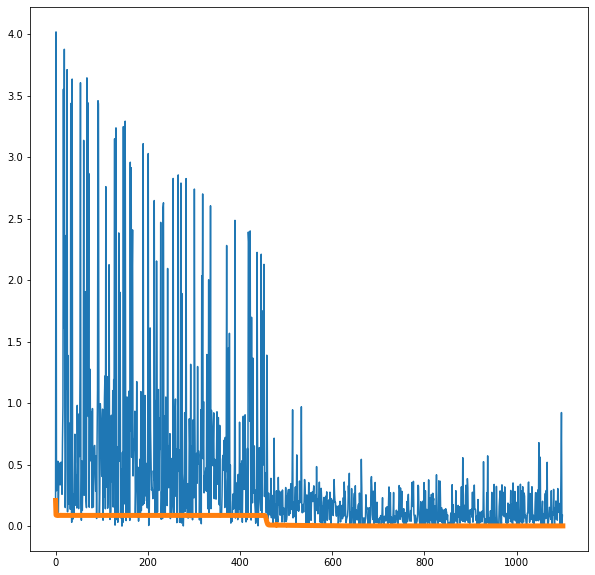

In [48]:
plt.figure(figsize=(10,10))
plt.plot(grad_norm_1.values())
plt.plot(val_losses_1,linewidth=5)
plt.show()

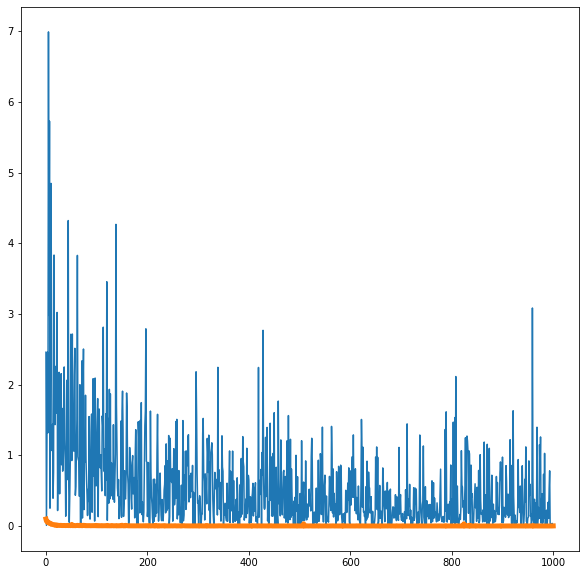

In [49]:
plt.figure(figsize=(10,10))
plt.plot(grad_norm_2.values())
plt.plot(val_losses_2,linewidth=5)
plt.show()

In [28]:
grad_norm_0
[index for index,value in enumerate(grad_norm_0) if value == 0.0]

[0]

In [29]:
grad_norm_0

{0: 0.33748737719117744,
 1: 0.3651247834469602,
 2: 0.5601432442564582,
 3: 0.04545136153493815,
 4: 0.15487616980804117,
 5: 0.17819891434336194,
 6: 0.20968082922881176,
 7: 0.6779903777523791,
 8: 1.8862305046506407,
 9: 0.6976024355381495,
 10: 0.5420399273620777,
 11: 0.16813296862768762,
 12: 0.6593513987055998,
 13: 0.4120411693960091,
 14: 0.36502437530677967,
 15: 0.3668170753047953,
 16: 1.8320093517323133,
 17: 0.3652264933611048,
 18: 0.5363512858618148,
 19: 0.26173200133529073,
 20: 0.37397139956248304,
 21: 1.0188388099662171,
 22: 0.39667007433077994,
 23: 0.691351894749326,
 24: 0.9469761477371091,
 25: 0.04571948919533037,
 26: 0.1433460814997692,
 27: 0.08971831900153479,
 28: 0.4254640361696442,
 29: 0.10624128872651999,
 30: 0.2842224734723163,
 31: 0.14566813660083625,
 32: 0.34260778067941505,
 33: 0.394057782630817,
 34: 0.686646848746156,
 35: 0.19282701275535746,
 36: 0.11426357999384651,
 37: 0.7007381773447672,
 38: 0.15919452253128177,
 39: 0.0202061138996

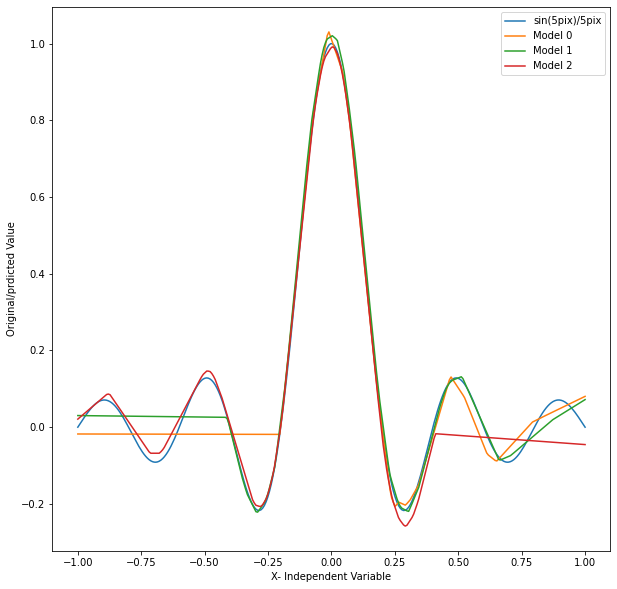

In [30]:
plt.figure(figsize=(10,10))
plt.plot(X,Y)
plt.plot(X,model_0(X).detach().numpy())
plt.plot(X,model_1(X).detach().numpy())
plt.plot(X,model_2(X).detach().numpy())

plt.xlabel('X- Independent Variable')
plt.ylabel('Original/prdicted Value')
plt.legend(['sin(5pix)/5pix','Model 0','Model 1','Model 2'])
plt.savefig("prediction_"+filename)

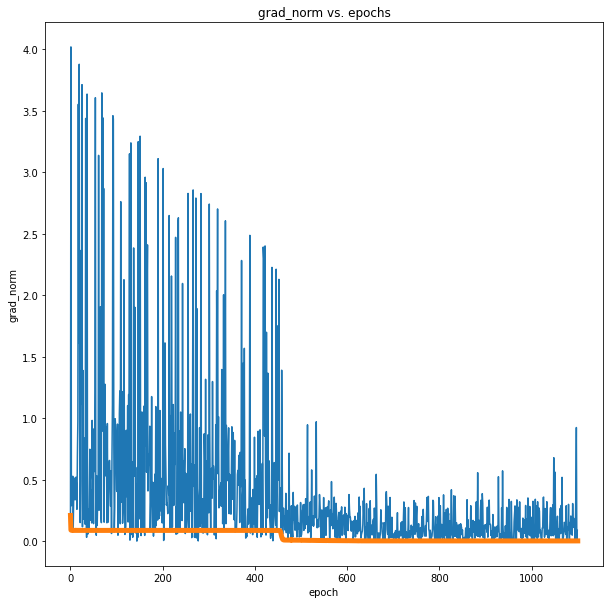

In [55]:
plt.figure(figsize=(10,10))
plt.plot(grad_norm_1.values())
plt.plot(val_losses_1,linewidth=5)
plt.xlabel('epoch')
plt.ylabel('grad_norm')
plt.title('grad_norm vs. epochs');

plt.savefig(result_folder+"/model1_afterstep.jpg")

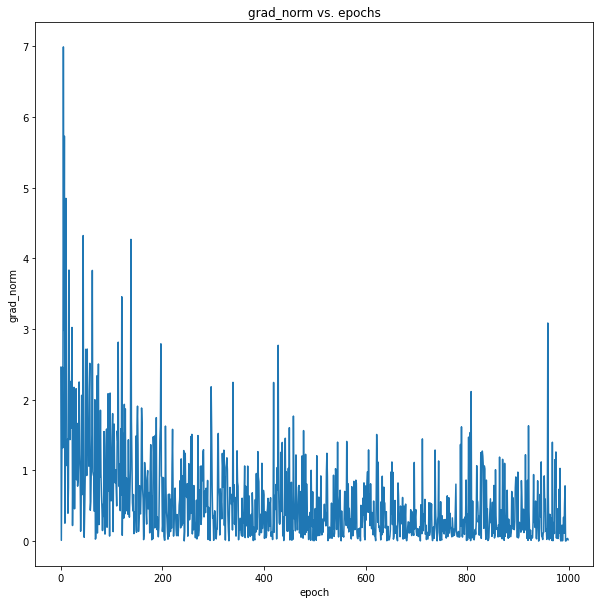

In [32]:
plt.figure(figsize=(10,10))
plt.plot(grad_norm_2.values())
plt.xlabel('epoch')
plt.ylabel('grad_norm')
plt.title('grad_norm vs. epochs');

plt.savefig(result_folder+"/model2_afterstep.jpg")

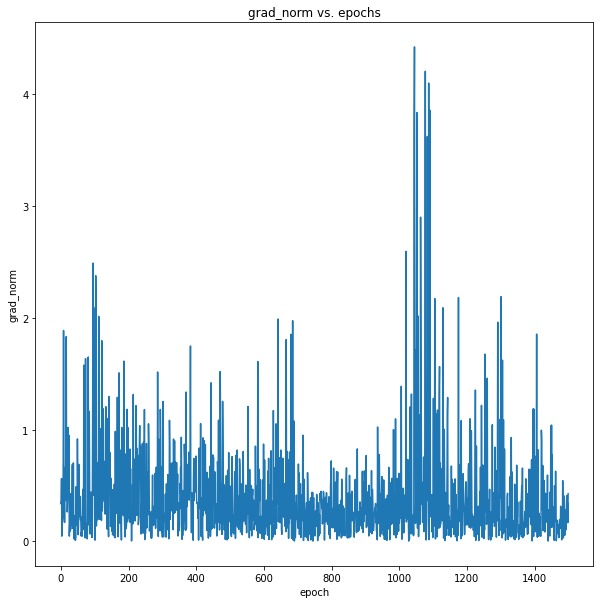

In [33]:
plt.figure(figsize=(10,10))
plt.plot(grad_norm_0.values())
plt.xlabel('epoch')
plt.ylabel('grad_norm')
plt.title('grad_norm vs. epochs');

plt.savefig(result_folder+"/model0_afterstep.jpg")

In [34]:
# code for Traning accuracy left

In [35]:
def accuracy(model,X,Y):
    _,preds = torch.max(model(X),dim=1)
    
    return torch.sum(preds == Y).item() / len(preds)

In [36]:
accuracy(model_0,X,Y)

0.0

In [37]:
accuracy(model_1,X,Y)

0.0

In [38]:
accuracy(model_2,X,Y)

0.0

In [39]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [40]:
get_n_params(model_0)

573

In [41]:
get_n_params(model_1)

574

In [42]:
get_n_params(model_2)

573